# GLM VS ML - Decision Tree Deconstruction and MC Simulations

![](https://datascience.foundation/img/pdf_images/understanding_decision_trees_with_python_decision_tree.png)

**Imports**

In [1]:
import importlib
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics
plt.style.use('seaborn')

## Auto Claims Data
**[Dataset](https://www.kaggle.com/xiaomengsun/car-insurance-claim-data)**

|VARIABLE NAME|DEFINITION                              |THEORETICAL EFFECT                                                                               |
|-------------|----------------------------------------|-------------------------------------------------------------------------------------------------|
|INDEX        |Identification Variable (do not use)    |None                                                                                             |
|TARGET FLAG  |Was Car in a crash? 1=YES 0=NO          |None                                                                                             |
|TARGET AMT   |If car was in a crash, what was the cost|None                                                                                             |
|AGE          |Age of Driver                           |Very young people tend to be risky. Maybe very old people also.                                  |
|BLUEBOOK     |Value of Vehicle                        |Unknown effect on probability of collision, but probably effect the payout if there is a crash   |
|CAR AGE      |Vehicle Age                             |Unknown effect on probability of collision, but probably effect the payout if there is a crash   |
|CAR TYPE     |Type of Car                             |Unknown effect on probability of collision, but probably effect the payout if there is a crash   |
|CAR USE      |Vehicle Use                             |Commercial vehicles are driven more, so might increase probability of collision                  |
|CLM FREQ     |# Claims (Past 5 Years)                 |The more claims you filed in the past, the more you are likely to file in the future             |
|EDUCATION    |Max Education Level                     |Unknown effect, but in theory more educated people tend to drive more safely                     |
|HOMEKIDS     |# Children at Home                      |Unknown effect                                                                                   |
|HOME VAL     |Home Value                              |In theory, home owners tend to drive more responsibly                                            |
|INCOME       |Income                                  |In theory, rich people tend to get into fewer crashes                                            |
|JOB          |Job Category                            |In theory, white collar jobs tend to be safer                                                    |
|KIDSDRIV     |# Driving Children                      |When teenagers drive your car, you are more likely to get into crashes                           |
|MSTATUS      |Marital Status                          |In theory, married people drive more safely                                                      |
|MVR PTS      |Motor Vehicle Record Points             |If you get lots of traffic tickets, you tend to get into more crashes                            |
|OLDCLAIM     |Total Claims (Past 5 Years)             |If your total payout over the past five years was high, this suggests future payouts will be high|
|PARENT1      |Single Parent                           |Unknown effect                                                                                   |
|RED CAR      |A Red Car                               |Urban legend says that red cars (especially red sports cars) are more risky. Is that true?       |
|REVOKED      |License Revoked (Past 7 Years)          |If your license was revoked in the past 7 years, you probably are a more risky driver.           |
|SEX          |Gender                                  |Urban legend says that women have less crashes then men. Is that true?                           |
|TIF          |Time in Force                           |People who have been customers for a long time are usually more safe.                            |
|TRAVTIME     |Distance to Work                        |Long drives to work usually suggest greater risk                                                 |
|URBANICITY   |Home/Work Area                          |Unknown                                                                                          |
|YOJ          |Years on Job                            |People who stay at a job for a long time are usually more safe                                   |


**Load Data and Clean Data**

In [2]:
# Load Data
df = pd.read_csv('~/Downloads/car_insurance_claim.csv')

# make columns lowercase
df.columns = df.columns.str.lower()

# drop useless columns
df = df.drop(['kidsdriv','parent1','revoked','mvr_pts','travtime','id','birth'],axis=1)

# clean money amounts
df[['home_val','bluebook','oldclaim','clm_amt','income']] = df[['home_val','bluebook','oldclaim','clm_amt','income']].apply(lambda x: x.str.replace('$','',regex=False).str.replace(',','',regex=False)).astype(float)

# clean values from columns
to_clean = ['education','occupation','mstatus','gender','car_type']
for col in to_clean:
    df[col] = df[col].str.replace('z_','',regex=False).str.replace('<','',regex=False)

df['urbanicity'] = df['urbanicity'].str.split('/ ',expand=True)[1]

to_clean = ['mstatus','red_car']
for col in to_clean:
    df[col] = df[col].str.lower().replace({ 'yes': True, 'no': False}).astype(int)
    
df = df.drop(['car_age','occupation','home_val','income','yoj'],axis=1).dropna()
  
df[:3]

,age,homekids,mstatus,gender,education,car_use,bluebook,tif,car_type,red_car,oldclaim,clm_freq,clm_amt,claim_flag,urbanicity
0,60.0,0,0,M,PhD,Private,14230.0,11,Minivan,1,4461.0,2,0.0,0,Urban
1,43.0,0,0,M,High School,Commercial,14940.0,1,Minivan,1,0.0,0,0.0,0,Urban
2,48.0,0,0,M,Bachelors,Private,21970.0,1,Van,1,0.0,0,0.0,0,Urban


**Select Features and Targets**

In [3]:
features = ['age','gender','car_type','red_car','tif','car_use','bluebook','oldclaim']
binary_target = 'claim_flag'
severity_target = 'clm_amt'

In [4]:
processed_data = df.copy()
processed_data = pd.get_dummies(processed_data)
processed_data.columns = processed_data.columns.str.replace(' ','_',regex=False)
processed_data_features = list(set(processed_data.columns.tolist()) - set([binary_target, severity_target]))
processed_data

,age,homekids,mstatus,bluebook,tif,red_car,oldclaim,clm_freq,clm_amt,claim_flag,...,car_use_Commercial,car_use_Private,car_type_Minivan,car_type_Panel_Truck,car_type_Pickup,car_type_SUV,car_type_Sports_Car,car_type_Van,urbanicity_Rural,urbanicity_Urban
0,60.0,0,0,14230.0,11,1,4461.0,2,0.0,0,...,0,1,1,0,0,0,0,0,0,1
1,43.0,0,0,14940.0,1,1,0.0,0,0.0,0,...,1,0,1,0,0,0,0,0,0,1
2,48.0,0,0,21970.0,1,1,0.0,0,0.0,0,...,0,1,0,0,0,0,0,1,0,1
3,35.0,1,1,4010.0,4,0,38690.0,2,0.0,0,...,0,1,0,0,0,1,0,0,0,1
4,51.0,0,1,15440.0,7,1,0.0,0,0.0,0,...,0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,45.0,2,1,13270.0,15,0,0.0,0,0.0,0,...,0,1,1,0,0,0,0,0,0,1
10298,46.0,0,1,24490.0,6,0,0.0,0,0.0,0,...,1,0,0,1,0,0,0,0,0,1
10299,48.0,0,1,13820.0,7,0,0.0,0,0.0,0,...,0,1,0,0,0,1,0,0,0,1
10300,50.0,0,1,22550.0,6,0,0.0,0,0.0,0,...,0,1,1,0,0,0,0,0,0,1


In [5]:
train, test = train_test_split(processed_data, test_size=0.45, random_state=42, stratify=processed_data[binary_target])

train_severity = train.loc[train[severity_target] > 0].copy()

### GLMs

**GLM Binomial Model**

In [6]:
binomial_train_X = sm.add_constant(train[processed_data_features])
binomial = sm.GLM(train[binary_target],binomial_train_X, family=sm.families.Binomial())
binomial_fitted = binomial.fit()
binomial_fitted.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             claim_flag   No. Observations:                 5662
Model:                            GLM   Df Residuals:                     5642
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2699.7
Date:                Wed, 08 Sep 2021   Deviance:                       5399.4
Time:                        08:01:37   Pearson chi2:                 5.69e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3794      0.083     -4.545      0.000      -0.543      -0.216
oldclaim               4.314e-06   3.93e-06      1.097      0.272   -3.39e-06     1.2e-05
mstatus                  -0.7470      0.069    -10.765      0.000      -0.883      -0.611
homekids                  0.2263      0.033      6.872      0.000       0.162       0.291
car_type_Minivan         -0.6441      0.076     -8.425      0.000      -0.794      -0.494
car_type_SUV              0.1979      0.098      2.013      0.044       0.005       0.391
gender_F                 -0.2921      0.077     -3.772      0.000      -0.444      -0.140
tif                      -0.0552      0.009     -6.429      0.000      -0.072      -0.038
urbanicity_Urban          0.9277      0.070     13.253      0.000       0.791       1.065
car_use_Private          -0.5704      0.059     -9.717      0.000      -0.686      -0.455
education_Bachelors      -0.1496      0.064     -2.323      0.020      -0.276      -0.023
red_car                  -0.0116      0.100     -0.117      0.907      -0.207       0.183
clm_freq                  0.2283      0.031      7.381      0.000       0.168       0.289
car_type_Van             -0.1026      0.110     -0.931      0.352      -0.319       0.113
car_type_Sports_Car       0.4894      0.117      4.174      0.000       0.260       0.719
education_High_School     0.5169      0.056      9.183      0.000       0.407       0.627
car_type_Pickup          -0.0557      0.078     -0.719      0.472      -0.208       0.096
car_use_Commercial        0.1911      0.059      3.234      0.001       0.075       0.307
education_PhD            -0.4956      0.102     -4.839      0.000      -0.696      -0.295
gender_M                 -0.0873      0.076     -1.143      0.253      -0.237       0.062
education_Masters        -0.2510      0.074     -3.370      0.001      -0.397      -0.105
age                      -0.0048      0.005     -1.061      0.289      -0.014       0.004
bluebook              -2.091e-05   5.84e-06     -3.580      0.000   -3.24e-05   -9.46e-06
urbanicity_Rural         -1.3071      0.084    -15.496      0.000      -1.472      -1.142
car_type_Panel_Truck     -0.2643      0.147     -1.804      0.071      -0.551       0.023
=========================================================================================
"""

In [7]:
gamma_train_X = sm.add_constant(train_severity[processed_data_features])
gamma = sm.GLM(train_severity[severity_target], gamma_train_X, family=sm.families.Gamma(sm.families.links.log()))
gamma_fitted = gamma.fit()
gamma_fitted.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                clm_amt   No. Observations:                 1507
Model:                            GLM   Df Residuals:                     1487
Model Family:                   Gamma   Df Model:                           19
Link Function:                    log   Scale:                          1.6922
Method:                          IRLS   Log-Likelihood:                -14770.
Date:                Wed, 08 Sep 2021   Deviance:                       1058.8
Time:                        08:01:37   Pearson chi2:                 2.52e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.7794      0.080     34.704      0.000       2.622       2.936
oldclaim              -2.059e-07   3.78e-06     -0.054      0.957   -7.62e-06    7.21e-06
mstatus                  -0.0083      0.069     -0.121      0.904      -0.143       0.127
homekids                  0.0142      0.031      0.462      0.644      -0.046       0.074
car_type_Minivan          0.5201      0.082      6.348      0.000       0.359       0.681
car_type_SUV              0.5023      0.100      5.046      0.000       0.307       0.697
gender_F                  1.3614      0.077     17.697      0.000       1.211       1.512
tif                      -0.0028      0.009     -0.322      0.748      -0.020       0.014
urbanicity_Urban          1.3660      0.075     18.215      0.000       1.219       1.513
car_use_Private           1.3636      0.057     24.057      0.000       1.252       1.475
education_Bachelors       0.6809      0.067     10.135      0.000       0.549       0.813
red_car                   0.0201      0.099      0.202      0.840      -0.175       0.215
clm_freq                 -0.0004      0.030     -0.013      0.990      -0.059       0.058
car_type_Van              0.4605      0.114      4.034      0.000       0.237       0.684
car_type_Sports_Car       0.5810      0.117      4.947      0.000       0.351       0.811
education_High_School     0.6913      0.057     12.147      0.000       0.580       0.803
car_type_Pickup           0.5635      0.076      7.368      0.000       0.414       0.713
car_use_Commercial        1.4158      0.058     24.398      0.000       1.302       1.530
education_PhD             0.7192      0.114      6.311      0.000       0.496       0.943
gender_M                  1.4180      0.076     18.643      0.000       1.269       1.567
education_Masters         0.6881      0.081      8.481      0.000       0.529       0.847
age                       0.0037      0.004      0.885      0.376      -0.004       0.012
bluebook               2.534e-05   5.79e-06      4.376      0.000     1.4e-05    3.67e-05
urbanicity_Rural          1.4134      0.096     14.715      0.000       1.225       1.602
car_type_Panel_Truck      0.1520      0.149      1.021      0.307      -0.140       0.444
=========================================================================================
"""

In [8]:
from ..modules import dt_deconstruction
importlib.reload(dt_deconstruction)
from ..modules.dt_deconstruction import DTRuler,DTRulerAvg

### Tree Based Models

In [9]:
size = 20
seed = 42
np.random.seed(seed)
dummy_data = pd.DataFrame({
    'car_type': np.random.choice(['Audi','BMW','Porsche'], size=size),
    'weight': np.random.normal(2500,size=size),
    'hp': np.random.randint(75,200,size=size),
    'speed': np.random.gamma(200,scale=np.random.choice([0.3, 0.5, 0.7, 1.2],size=size),size=size)
})
dummy_data = pd.get_dummies(dummy_data)
dummy_features = dummy_data.drop(['speed'],axis=1).columns.tolist()
dummy_data[:10]

,weight,hp,speed,car_type_Audi,car_type_BMW,car_type_Porsche
0,2499.536582,158,244.095606,0,0,1
1,2499.534270,166,111.887765,1,0,0
2,2500.241962,185,53.724425,0,0,1
3,2498.086720,134,147.025377,0,0,1
4,2498.275082,145,99.526054,1,0,0
5,2499.437712,118,97.900889,1,0,0
6,2498.987169,199,255.728305,0,0,1
7,2500.314247,82,104.698847,0,1,0
8,2499.091976,121,104.585972,0,0,1
9,2498.587696,109,101.546611,0,0,1


In [10]:
rf_reg = ensemble.RandomForestRegressor(n_estimators=3, random_state=seed)
rf_reg.fit(dummy_data[dummy_features], dummy_data['speed'])

RandomForestRegressor(n_estimators=3, random_state=42)

In [11]:
rf_reg.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(max_features='auto', random_state=1935803228)]

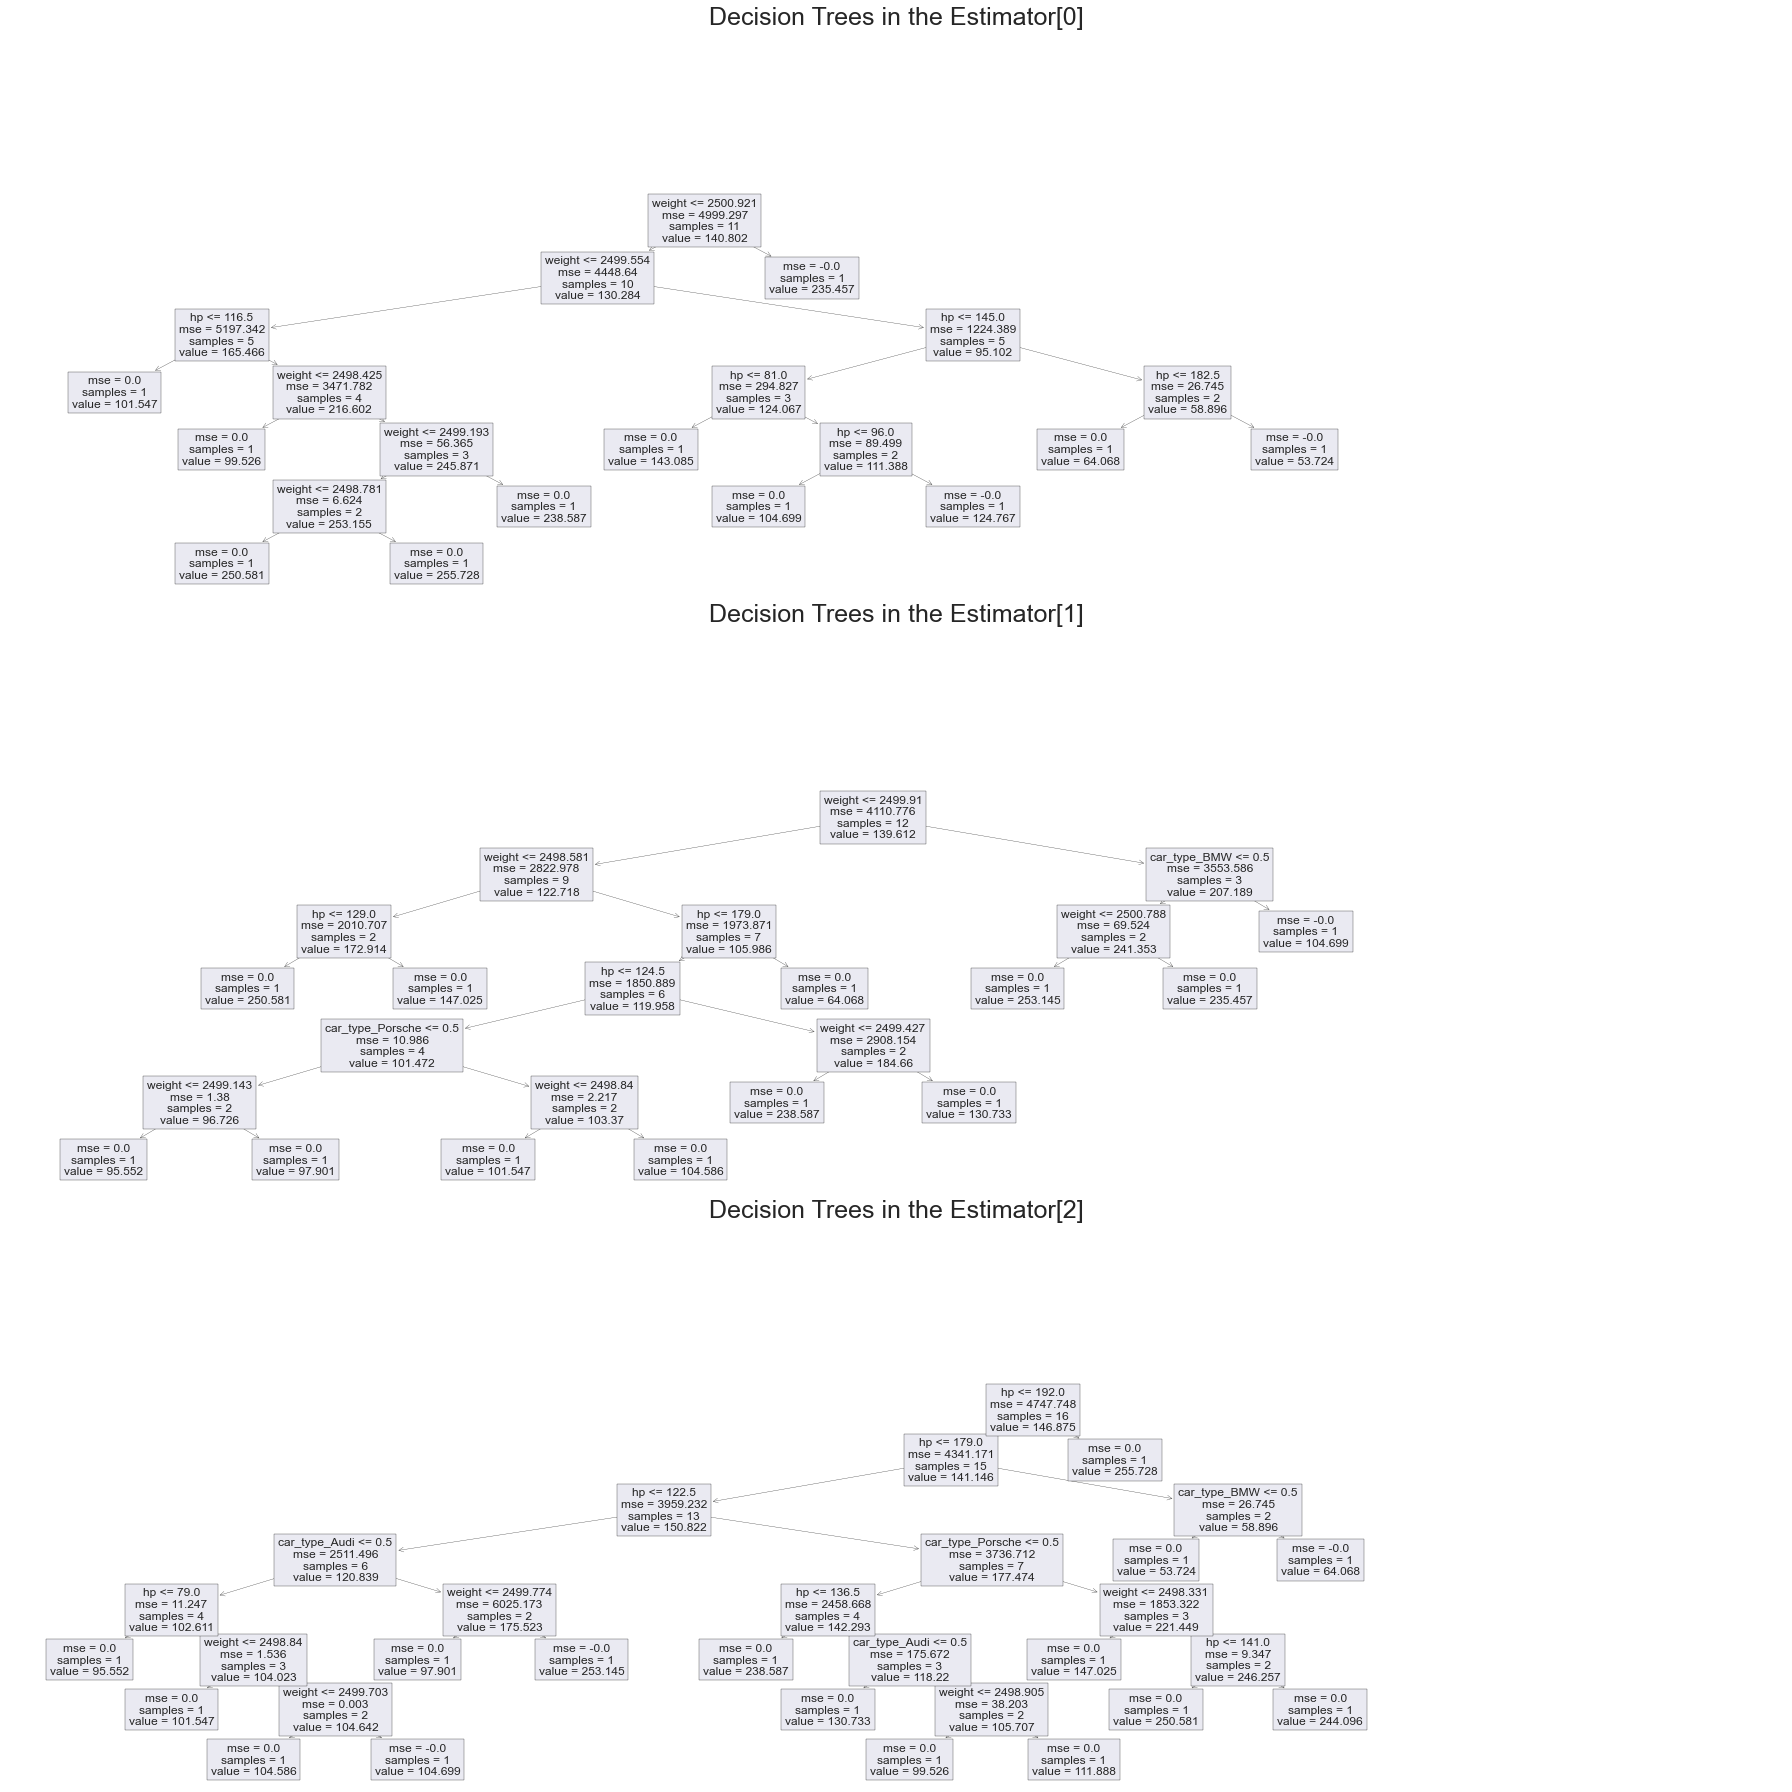

In [12]:
fig,axs = plt.subplots(3,1,figsize=(25,25))
for i, es in enumerate(rf_reg.estimators_):
    
    tree.plot_tree(es,feature_names=dummy_features, ax=axs[i],fontsize=12);
    axs[i].set_title(f'Decision Trees in the Estimator[{i}]',fontsize=25)
    
plt.tight_layout()

**Decision Tree Classifier Model**

In [13]:
clf = ensemble.RandomForestClassifier(n_estimators=10,random_state=seed)
clf.fit(train[processed_data_features],train[binary_target])

RandomForestClassifier(n_estimators=10, random_state=42)

**Decision Tree Regressor Model**

In [14]:
reg = ensemble.RandomForestRegressor(n_estimators=10, random_state=seed)
reg.fit(train_severity[processed_data_features], train_severity[severity_target])

RandomForestRegressor(n_estimators=10, random_state=42)

### Tree Deconstruction

DTRulerAvg will deconstruct the decision trees and extract the datafiltering rules

In [15]:
%%time
clf_dtruler = dt_deconstruction.DTRulerAvg(model=clf,training_data=train,features=processed_data_features)

CPU times: user 35.9 s, sys: 100 ms, total: 36 s
Wall time: 36 s


In [16]:
%%time
reg_dtruler = dt_deconstruction.DTRulerAvg(model=reg,training_data=train_severity,features=processed_data_features)

CPU times: user 18.7 s, sys: 65 ms, total: 18.8 s
Wall time: 18.8 s


In [17]:
def custom_func(d):
    return {
        'mean': d.mean(),
        'std': d.std(),
        'var': d.var()
    }

After we have our instances for DT rulers we can call the predict method which will concatenate all the samples from training data that matches the decision path for the given sample, in the same time we pass our custom aggregation function which will calculate in the currentc case mean, std and variance for the target variable in each data group/cluster

In [18]:
%%time
clf_data_by_avg_trees = clf_dtruler.predict(test.reset_index(), aggfunc=lambda x: custom_func(x[binary_target]))

CPU times: user 6min 10s, sys: 682 ms, total: 6min 10s
Wall time: 6min 11s


In [19]:
%%time
reg_data_by_avg_trees = reg_dtruler.predict(test.reset_index(), aggfunc=lambda x: custom_func(x[severity_target]))

CPU times: user 7min 1s, sys: 542 ms, total: 7min 1s
Wall time: 7min 1s


Then we want to validate our distributions from each group/cluster against the original distribution and to do that we'll use the next statistica test.

### Kolmogorov-Smirnov test
Performs the (one-sample or two-sample) Kolmogorov-Smirnov test for goodness of fit.

The one-sample test compares the underlying distribution F(x) of a sample against a given distribution G(x). 

The two-sample test compares the underlying distributions of two independent samples. 

Both tests are valid only for continuous distributions.

In [20]:
reg_data_by_avg_trees_copy = reg_data_by_avg_trees.copy()
clf_data_by_avg_trees_copy = clf_data_by_avg_trees.copy()

Compute the statistical test for each group

In [21]:
%%time
reg_data_by_avg_trees_copy_kstest = reg_data_by_avg_trees_copy.all_trees_data.apply(lambda x: ss.kstest(x[severity_target], test.loc[test[severity_target]>0,severity_target]))
clf_data_by_avg_trees_copy_kstest = clf_data_by_avg_trees_copy.all_trees_data.apply(lambda x: ss.kstest(x[binary_target], test[binary_target]))

CPU times: user 1min 21s, sys: 158 ms, total: 1min 22s
Wall time: 1min 21s


Extract the statisict score and the P-values

In [22]:
reg_data_by_avg_trees_copy[['kstest_statistic','kstest_pvalue']] = pd.DataFrame.from_dict(reg_data_by_avg_trees_copy_kstest.apply(lambda x: dict(kstest_statistic=x.statistic, kstest_pvalue=x.pvalue)).values.tolist()).values
reg_data_by_avg_trees_copy['statistical_significant'] = reg_data_by_avg_trees_copy['kstest_pvalue'].between(-0.05,0.05)

In [23]:
clf_data_by_avg_trees_copy[['kstest_statistic','kstest_pvalue']] = pd.DataFrame.from_dict(clf_data_by_avg_trees_copy_kstest.apply(lambda x: dict(kstest_statistic=x.statistic, kstest_pvalue=x.pvalue)).values.tolist()).values
clf_data_by_avg_trees_copy['statistical_significant'] = clf_data_by_avg_trees_copy['kstest_pvalue'].between(-0.05,0.05)

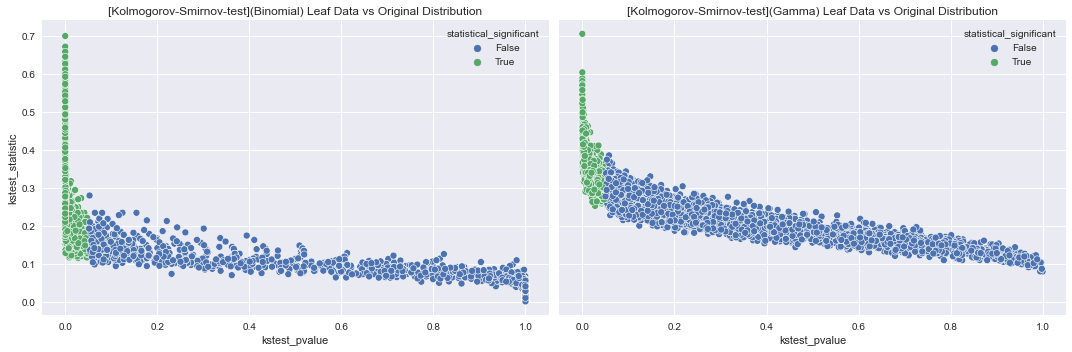

In [24]:
fig,axs = plt.subplots(1,2,figsize=(15,5),sharey=True)
sns.scatterplot(data=clf_data_by_avg_trees_copy, x='kstest_pvalue',y='kstest_statistic',hue='statistical_significant',ax=axs[0]);
sns.scatterplot(data=reg_data_by_avg_trees_copy, x='kstest_pvalue',y='kstest_statistic',hue='statistical_significant',ax=axs[1]);
axs[0].set_title('[Kolmogorov-Smirnov-test](Binomial) Leaf Data vs Original Distribution')
axs[1].set_title('[Kolmogorov-Smirnov-test](Gamma) Leaf Data vs Original Distribution')
plt.tight_layout()

## Monte Carlo Simulations

Now that we validated our distributions, we want to apply Monte Carlo Simiulations using the extracted parameters from DT ruler and compare the results aginast the GLM models

Add constant to the test dataframe

In [25]:
X_test = sm.add_constant(test[processed_data_features])

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Estimate the gama scale for each group/cluster

In [26]:
estimated_scale = 1 / (reg_data_by_avg_trees_copy['mean'] / reg_data_by_avg_trees_copy['std']) ** 2
reg_data_by_avg_trees_copy['estimated_scale'] = estimated_scale

Simulate frequency and severity for policies

In [27]:
years = 1000

test_copy = test[[binary_target,severity_target]].copy().reset_index().drop(['index'],axis=1)

test_copy['glm_binomial_prediction'] = binomial_fitted.predict(X_test).values
test_copy['tree_binomial_prediction'] = clf.predict_proba(test[processed_data_features])[:,1]

test_copy['glm_gamma_prediction'] = gamma_fitted.predict(X_test).values
test_copy['tree_gamma_prediction'] = reg.predict(test[processed_data_features])


test_copy['glm_binomial_simulation'] = pd.Series(binomial_fitted.get_prediction(X_test).se_mean).apply(lambda x: np.random.binomial(1, p=x,size=years).mean()).values
test_copy['tree_binomial_simulation'] = clf_data_by_avg_trees_copy['mean'].apply(lambda x: np.random.binomial(1, p=x,size=years).mean()).values

test_copy['glm_gamma_simulation'] = pd.Series(gamma_fitted.get_prediction(X_test).se_mean).apply(lambda x: np.random.gamma(x, scale=gamma_fitted.scale,size=years).mean()).values
test_copy['tree_gamma_simulation'] = reg_data_by_avg_trees_copy.apply(lambda x: np.random.gamma(x['mean'], scale=x['estimated_scale'],size=years).mean() ,axis=1).values

test_copy

,claim_flag,clm_amt,glm_binomial_prediction,tree_binomial_prediction,glm_gamma_prediction,tree_gamma_prediction,glm_binomial_simulation,tree_binomial_simulation,glm_gamma_simulation,tree_gamma_simulation
0,0,0.0,0.150853,0.3,10005.852086,14326.5,0.034,0.177,3773.346751,11757.349365
1,0,0.0,0.286394,0.4,6138.720682,10049.7,0.035,0.100,1977.283884,9853.675006
2,1,3585.0,0.545713,0.8,7792.679881,4658.3,0.043,0.705,2007.933873,4792.402107
3,0,0.0,0.182635,0.2,6682.003823,6475.3,0.023,0.124,1864.553406,3190.879903
4,0,0.0,0.445982,0.6,4152.852101,2864.0,0.026,0.569,715.139182,1319.027586
...,...,...,...,...,...,...,...,...,...,...
4628,1,2950.0,0.338865,0.4,6066.116225,3770.9,0.027,0.202,1595.149568,5246.726108
4629,1,7400.0,0.309174,0.3,6140.992509,2263.2,0.038,0.149,2061.907107,1321.695099
4630,1,4579.0,0.340097,0.3,7654.724768,7902.1,0.031,0.307,1906.700495,9565.071580
4631,1,6022.0,0.259748,0.3,5502.448698,7974.8,0.024,0.316,1148.829141,11496.647957


**Actual Claim Frequency distribution against the Predicted and Simulated**

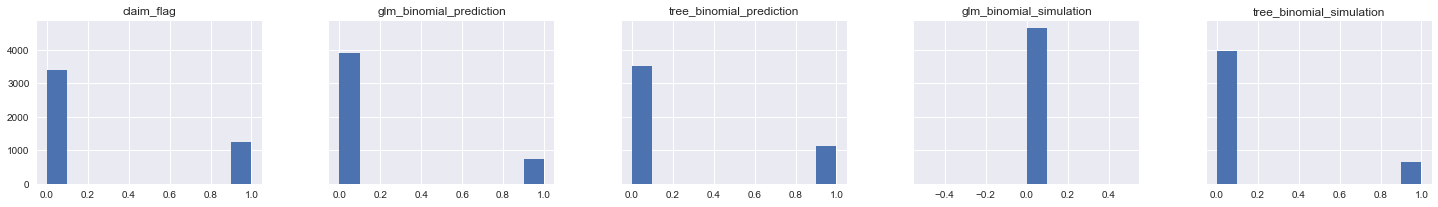

In [28]:
test_copy[['claim_flag','glm_binomial_prediction','tree_binomial_prediction','glm_binomial_simulation','tree_binomial_simulation',]].applymap(
lambda x: 1 if x >=0.5 else 0
).hist(layout=(1,5),figsize=(25,3),sharey=True);

In [29]:
tmp = test_copy[['claim_flag','glm_binomial_prediction','tree_binomial_prediction','glm_binomial_simulation','tree_binomial_simulation',]].applymap(
lambda x: 1 if x >=0.5 else 0)

for x in ['glm_binomial_prediction','tree_binomial_prediction','glm_binomial_simulation','tree_binomial_simulation']:
    print(f'\nactual claims frequency vs {x}\n[accuracy_score={metrics.accuracy_score(tmp["claim_flag"],tmp[x])}, recall_score={metrics.recall_score(tmp["claim_flag"],tmp[x])}, f1_score={metrics.f1_score(tmp["claim_flag"],tmp[x])}]')


actual claims frequency vs glm_binomial_prediction
[accuracy_score=0.7750917332182171, recall_score=0.37550689375506896, f1_score=0.47052845528455284]

actual claims frequency vs tree_binomial_prediction
[accuracy_score=0.7299805741420246, recall_score=0.4468775344687753, f1_score=0.4683382915427114]

actual claims frequency vs glm_binomial_simulation
[accuracy_score=0.7338657457371034, recall_score=0.0, f1_score=0.0]

actual claims frequency vs tree_binomial_simulation
[accuracy_score=0.7617094755018347, recall_score=0.32116788321167883, f1_score=0.4177215189873418]


**Actual Claim Severity distribution against the Predicted and Simulated**

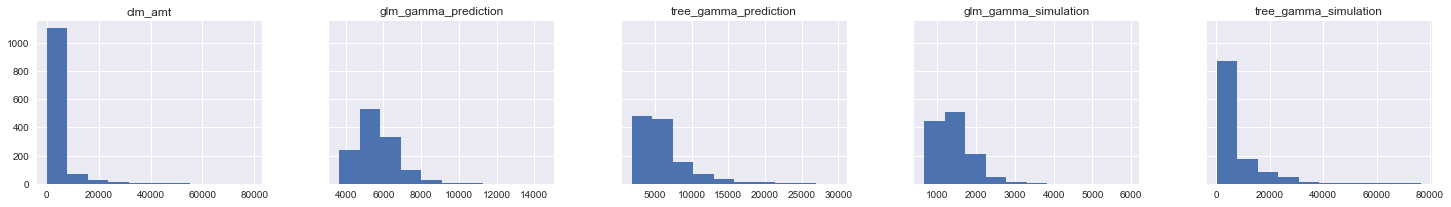

In [30]:
test_copy.loc[test_copy.clm_amt>0][['clm_amt','glm_gamma_prediction','tree_gamma_prediction','glm_gamma_simulation','tree_gamma_simulation',]].hist(layout=(1,5),figsize=(25,3),sharey=True);

In [31]:
tmp = test_copy.loc[test_copy.clm_amt>0][['clm_amt','glm_gamma_prediction','tree_gamma_prediction','glm_gamma_simulation','tree_gamma_simulation',]]

for x in ['glm_gamma_prediction','tree_gamma_prediction','glm_gamma_simulation','tree_gamma_simulation',]:
    print(f'\nactual claims severity vs {x}\n[RMSE={metrics.mean_squared_error(tmp["clm_amt"],tmp[x], squared=False)}]')


actual claims severity vs glm_gamma_prediction
[RMSE=7258.709605379099]

actual claims severity vs tree_gamma_prediction
[RMSE=7801.673419812962]

actual claims severity vs glm_gamma_simulation
[RMSE=8381.243766533747]

actual claims severity vs tree_gamma_simulation
[RMSE=13148.207709796603]


### Conclusions

- POC of how we can deconstruct and use DT for Simulations
- Was a nice and insightful exercise that helped in having a better understanding of DT and how they work behinde the nice sklearn wrapper
- If Tree based models were not handling data-drifting that good, well now with deconstruction that might be even worse